In [1]:
from extract import SocialETL, construct_query_for_twarc, extract_tags, SocialDB, UserETL
from extract import CategorizeUsers
import hashtags as h
import hashtags_readcsv as r_csv
import pandas as pd
import numpy as np
import json
import networkx as nx
from numpy import nan

# 1) Download DF

In [22]:
m1 = SocialETL(query="(#slavaukraini OR #stopwarinukraine OR #istandwithputin) is:retweet", pages=500, recent=False) 

Reading secret from C:\Users\david\Documents\GitHub\ds-network-analysis\data\my_secrets.yaml…

Output()

In [23]:
m1.df=m1.df.dropna(subset=['entities.hashtags'])
m1.df=m1.df.dropna(subset=['retweeted_user_id'])

In [24]:
m1.df['entities.hashtags']=m1.df['entities.hashtags'].apply(eval)
m1.df['entities.hashtags']=m1.df['entities.hashtags'].map(h.extract_tags)

In [25]:
df_nodes=pd.DataFrame({"user_id":m1.df['author_id'],
                       'tweet_id':m1.df['id'],
                      'retweet_id': m1.df['retweeted_user_id'],
                      "hashtag":m1.df['entities.hashtags'],
                     'location':m1.df['author.location'],
                     'verified':m1.df['author.verified']
                      })

In [26]:
#df_proukr.set_index('user_id',inplace=True)
df_nodes.shape

(44812, 6)

In [27]:
df_nodes.to_csv('df_nodes')

## preprocessing 

In [2]:
df_nodes=pd.read_csv('df_nodes.csv')
del df_nodes['Unnamed: 0']

In [3]:
df_nodes=df_nodes.set_index('user_id') #,inplace=True)

In [4]:
df_nodes

,tweet_id,retweet_id,hashtag,location,verified
user_id,,,,,
1007449601400541184,1503521257177948170,278369814,"['putin', 'slavaukraini']","Mobile, AL",False
1464582321533767695,1503521249850363904,291496884,"['stopputin', 'stopwar', 'stopwarinukraine']",NaN,False
1245946724994158592,1503521066739589120,3312966191,"['standwithukraine', 'stopputinnow', 'slavaukr...",NaN,False
854862661,1503521023450361861,465973,['slavaukraini'],NaN,False
42746752,1503520988297932802,1456400208431091712,"['dogsoftwittter', 'dogsoftwitter', 'stoprussi...","Northeast Ohio, USA",False
...,...,...,...,...,...
396145409,1501662088846061577,191393940,"['slavaukraini', 'standwithukraine']","West Midlands, England",False
1486393266782314498,1501662072094048266,279390084,"['fckptn', 'slavaukraini']",NaN,False
1390353643,1501662038195638272,1192160073897988096,"['standwithukraine', 'istandwithukraine', 'sla...",County Cork,False


In [5]:
df_nodes.index=df_nodes.index.map(int)
df_nodes['hashtag']=df_nodes['hashtag'].map(str).apply(eval)
df_nodes['tweet_id']=df_nodes['tweet_id'].map(str).apply(eval)
df_nodes['retweet_id']=df_nodes['retweet_id'].map(str).apply(eval)
df_nodes['location']=df_nodes['location'].map(str)#.apply(eval)
df_nodes['verified']=df_nodes['verified'].map(str).apply(eval)

In [6]:
df_nodes.shape

(47853, 5)

In [7]:
df_nodes.head(3)

,tweet_id,retweet_id,hashtag,location,verified
user_id,,,,,
1007449601400541184,1503521257177948170,278369814,"[putin, slavaukraini]","Mobile, AL",False
1464582321533767695,1503521249850363904,291496884,"[stopputin, stopwar, stopwarinukraine]",nan,False
1245946724994158592,1503521066739589120,3312966191,"[standwithukraine, stopputinnow, slavaukraini]",nan,False


In [8]:
#convert nested lists on set
def to_sets(nested_lists): 
    outer_list = set()
    for el in nested_lists: 
        if type(el) == list: 
            outer_list.update(el) 
        else: 
            outer_list.add(el)
    return outer_list
df_nodes['hashtag']=df_nodes['hashtag'].map(to_sets)

In [9]:
df_nodes.head(3)

,tweet_id,retweet_id,hashtag,location,verified
user_id,,,,,
1007449601400541184,1503521257177948170,278369814,"{slavaukraini, putin}","Mobile, AL",False
1464582321533767695,1503521249850363904,291496884,"{stopwarinukraine, stopputin, stopwar}",nan,False
1245946724994158592,1503521066739589120,3312966191,"{stopputinnow, standwithukraine, slavaukraini}",nan,False


In [10]:
df_nodes.loc[df_nodes['location']=='nan']

,tweet_id,retweet_id,hashtag,location,verified
user_id,,,,,
1464582321533767695,1503521249850363904,291496884,"{stopwarinukraine, stopputin, stopwar}",nan,False
1245946724994158592,1503521066739589120,3312966191,"{stopputinnow, standwithukraine, slavaukraini}",nan,False
854862661,1503521023450361861,465973,{slavaukraini},nan,False
1298987457908633602,1503520942147969038,81599450,"{slavaukraini, johnsonout49}",nan,False
1265688143698685952,1503520921038245888,1437315069000314888,"{ukraine, slavaukraini, taipei}",nan,False
...,...,...,...,...,...
1438502419801903108,1501662278235602951,1496810215680978954,"{russia, ukraine, kyiv, ukraineunderattack, ru...",nan,False
1325145636153356290,1501662276977311750,191393940,"{slavaukraini, standwithukraine}",nan,False
4033666373,1501662191811977221,1205226529455632385,{slavaukraini},nan,False


# 2) Categorizzazione utenti

In [11]:
set_user=set(df_nodes.index)
print(len(set_user))

32382


In [ ]:
cat = CategorizeUsers(set_user, pages=1) #max_results=100 from 15-2 to 15-3

In [12]:
with open('categorize.json', 'r') as f:
    cat = json.load(f)
cat

{'1126026130203582464': 'proukr',
 '1301204310206840833': 'proukr',
 '1276426094242127874': 'proukr',
 '914089454511439875': 'proukr',
 '892318583748820994': 'proukr',
 '1233535933154197508': 'proukr',
 '1321173403429150726': 'proukr',
 '1265033587335757828': 'proukr',
 '1497612213766471688': 'proukr',
 '1410177732483317769': 'proukr',
 '1496871443505815561': 'proukr',
 '1357708828083683331': 'proukr',
 '1243995914341056517': 'proukr',
 '1316629728296566789': 'proukr',
 '1374989164664520711': 'proukr',
 '1473401352567070726': 'proukr',
 '1384173653743443975': 'proukr',
 '1444306356073340936': 'proukr',
 '1497189220443693066': 'proukr',
 '1437164333931372557': 'proukr',
 '42991636': 'proukr',
 '1472639914059702289': 'proukr',
 '54566935': 'proukr',
 '1497132750205247512': 'proukr',
 '288718876': 'proukr',
 '295231519': 'proukr',
 '1496946156487819297': 'proukr',
 '1310289087702630447': 'proukr',
 '515006515': 'proukr',
 '3338772538': 'proukr',
 '1286905933': 'proukr',
 '15794264': 'prou

In [16]:
c_proukr = 0
c_pax = 0
c_nocare = 0
c_prorus= 0

for v in cat.values():
    if v == "proukr":
        c_proukr += 1 
    elif v == "pax":
        c_pax += 1
    elif v == "prorus":
        c_prorus += 1
    else:
        c_nocare += 1

print('TOT USERS = {} \n'
      'proukr = {} \n'
      'pax = {} \n'
      'prorus = {} \n'
      'nocare = {} \n'.format(len(cat),c_proukr,c_pax, c_prorus, c_nocare))

TOT USERS = 32382 
proukr = 21987 
pax = 6921 
prorus = 1266 
nocare = 2208 



In [18]:
user_node=[]
user_cat=[]
for k,v in cat.items():
    user_node.append(k)
    user_cat.append(v)

In [28]:
df_cat=pd.DataFrame({'user_id':user_node,
                     'cat': user_cat})
df_cat=df_cat.set_index('user_id')
df_cat.index=df_cat.index.map(int)

In [29]:
df_cat

,cat
user_id,
1126026130203582464,proukr
1301204310206840833,proukr
1276426094242127874,proukr
914089454511439875,proukr
892318583748820994,proukr
...,...
14106605,proukr
2243559410,proukr
978460662,proukr


In [30]:
#copy of the dataset with distinct index
#copy because duplicates need to accounted to assign weights
df_nodes_copy = df_nodes[~df_nodes.index.duplicated(keep='first')]
df_nodes_copy

,tweet_id,retweet_id,hashtag,location,verified
user_id,,,,,
1007449601400541184,1503521257177948170,278369814,"{slavaukraini, putin}","Mobile, AL",False
1464582321533767695,1503521249850363904,291496884,"{stopwarinukraine, stopputin, stopwar}",nan,False
1245946724994158592,1503521066739589120,3312966191,"{stopputinnow, standwithukraine, slavaukraini}",nan,False
854862661,1503521023450361861,465973,{slavaukraini},nan,False
42746752,1503520988297932802,1456400208431091712,"{stopputin, dogsoftwittter, puppy, stoprussia,...","Northeast Ohio, USA",False
...,...,...,...,...,...
396145409,1501662088846061577,191393940,"{slavaukraini, standwithukraine}","West Midlands, England",False
1486393266782314498,1501662072094048266,279390084,"{fckptn, slavaukraini}",nan,False
1390353643,1501662038195638272,1192160073897988096,"{istandwithukraine, standwithukraine, slavaukr...",County Cork,False


In [31]:
df_final=pd.concat(objs=[df_nodes_copy,df_cat], axis=1)

In [32]:
df_final

,tweet_id,retweet_id,hashtag,location,verified,cat
user_id,,,,,,
290883,1502663077191426051,2956836471,"{nhsbadbill, johnsonout47, slavaukraini}",European Union,False,pax
298073,1503178785746685954,889765401822973952,{slavaukraini},nan,False,proukr
611093,1501988978345627654,56698771,"{standwithukraine, stopputinswar, stopputin, w...",istanbul,False,pax
699793,1502982769219371008,154830217,"{slavaukraini, ukrainerussiawar}",Pale Blue Dot/127.0.0.1,False,pax
756049,1502704662138568705,1255561430,"{ukraine, slavaukraini}",France,False,proukr
...,...,...,...,...,...,...
1503222685484081154,1503248107512942593,1447150441481965568,"{protestnato, standwithrussia, supportrussia, ...",nan,False,proukr
1503274603770171392,1503280632209756160,1390437709286715403,"{putler, istandwithputin}",nan,False,proukr
1503322318461968385,1503421219877568515,1455570393368956936,"{standwithputin, istandwithputin, standwithrus...",Occupied America,False,proukr


In [ ]:
df_final.to_csv('df_final')

# 3 Creazione rete

In [63]:
G = nx.Graph()

In [64]:
for i,e in df_final.iterrows():
    G.add_node(i, category=df_final['cat'][i], location=df_final['location'][i])# verified=df_final['verified'][i],

In [66]:
#list(G.nodes.data())

In [37]:
#PRIMA DATASET-->POI DIZIONARIO--->POI COLLEGARE LINK CON NODI + PESI
from_u=[]
to_u=[]
for u, user in enumerate(df_nodes.index):
    #print('u',user, type(user))
    for r,ret in enumerate(df_nodes['retweet_id']):
        #print('ret',ret, type(ret))
        if user==ret and user!=df_nodes.index[r]:
                from_u.append(user)
                to_u.append(df_nodes.index[r])

In [38]:
df=pd.DataFrame({'from':from_u,
                'to':to_u})
df.shape

(198199, 2)

In [39]:
df_weighted = df.value_counts().to_frame("weights").reset_index()
df_weighted.head(3)

,from,to,weights
0,2202063265,1081484761934319623,2496
1,1380145054644379652,1402929890442285056,1681
2,820731335157383170,615660889,1274


In [40]:
df_weighted["weights"] = (df_weighted["weights"] - (df_weighted["weights"]).min())/((df_weighted["weights"].max()-(df_weighted["weights"]).min()))
df_weighted.head(3)

,from,to,weights
0,2202063265,1081484761934319623,1.000000
1,1380145054644379652,1402929890442285056,0.673347
2,820731335157383170,615660889,0.510220


In [41]:
df_weighted.shape

(11663, 3)

In [22]:
df_weighted.to_csv('df_weighted')

In [67]:
df_weighted=pd.read_csv('df_weighted')
del df_weighted['Unnamed: 0']

In [68]:
for i,e in df_weighted.iterrows():
    G.add_edge(df_weighted['from'][i],df_weighted['to'][i], w=df_weighted['weights'][i] )

In [69]:
G.remove_edges_from(list(nx.selfloop_edges(G)))
G.remove_nodes_from(list(nx.isolates(G)))

In [70]:
#list(G.edges.data())

number of nodes = 11197 , number of edges = 12767 . number of components = 225


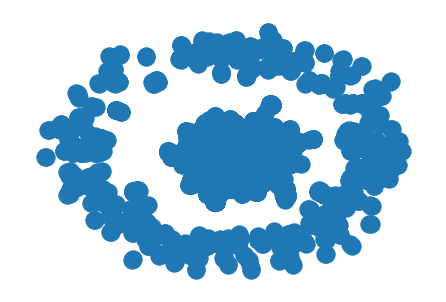

In [71]:
c=0
for component in list(nx.connected_components(G)):
    c += 1
nx.draw(G)
print('number of nodes =',G.number_of_nodes(),', number of edges =', G.number_of_edges(),'. number of components =',c) 

In [72]:
nx.write_gexf(G,'first_net.gexf')
#nx.write_gexf(G,'net_50')

In [2]:
G=nx.read_gexf('first_net.gexf')

In [3]:
[len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]

[10184,
 37,
 33,
 28,
 26,
 21,
 19,
 18,
 18,
 16,
 16,
 14,
 14,
 14,
 13,
 13,
 12,
 12,
 11,
 10,
 9,
 9,
 8,
 8,
 8,
 8,
 8,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2]

In [4]:
S = [G.subgraph(c).copy() for c in nx.connected_components(G)]
print(len(S))

225


In [5]:
for e in S:
    print(e)

Graph with 10184 nodes and 11968 edges
Graph with 2 nodes and 1 edges
Graph with 3 nodes and 2 edges
Graph with 5 nodes and 4 edges
Graph with 37 nodes and 40 edges
Graph with 3 nodes and 2 edges
Graph with 4 nodes and 3 edges
Graph with 6 nodes and 5 edges
Graph with 3 nodes and 2 edges
Graph with 3 nodes and 2 edges
Graph with 2 nodes and 1 edges
Graph with 2 nodes and 1 edges
Graph with 18 nodes and 20 edges
Graph with 7 nodes and 6 edges
Graph with 2 nodes and 1 edges
Graph with 2 nodes and 1 edges
Graph with 14 nodes and 13 edges
Graph with 11 nodes and 10 edges
Graph with 14 nodes and 13 edges
Graph with 6 nodes and 5 edges
Graph with 28 nodes and 27 edges
Graph with 6 nodes and 5 edges
Graph with 6 nodes and 5 edges
Graph with 26 nodes and 25 edges
Graph with 3 nodes and 2 edges
Graph with 3 nodes and 2 edges
Graph with 16 nodes and 15 edges
Graph with 2 nodes and 1 edges
Graph with 3 nodes and 2 edges
Graph with 6 nodes and 5 edges
Graph with 3 nodes and 2 edges
Graph with 5 no

In [74]:
for i,e in enumerate(S):
    print('component',i)
    print(list(e.nodes.data()))

component 0
[(290883, {'category': 'pax', 'verified': False, 'location': 'European Union'}), (1471971, {'category': 'proukr', 'verified': False, 'location': 'nan'}), (2052911, {'category': 'pax', 'verified': False, 'location': 'London, England'}), (2827221, {'category': 'dontcare', 'verified': False, 'location': 'NYC'}), (3688111, {'category': 'proukr', 'verified': False, 'location': 'Bangkok'}), (4254951, {'category': 'proukr', 'verified': False, 'location': 'Berkeley CA'}), (4615341, {'category': 'proukr', 'verified': False, 'location': 'Paris of the Piedmont'}), (4937571, {'category': 'pax', 'verified': False, 'location': 'Moss Beach, CA'}), (5404582, {'category': 'pax', 'verified': False, 'location': 'Lugano'}), (5516892, {'category': 'proukr', 'verified': False, 'location': 'Chicago, IL'}), (5749002, {'category': 'proukr', 'verified': False, 'location': "Martha's Vineyard, USA"}), (5849252, {'category': 'proukr', 'verified': False, 'location': 'Ocean City, Maryland'}), (6266142, {

In [15]:
#remove small components
c=0
th=40
for component in list(nx.connected_components(G)):
    c += 1
    if len(component)<th:
        for node in component:
            G.remove_node(node)

number of nodes = 10184 , number of edges = 11968 . number of components = 1


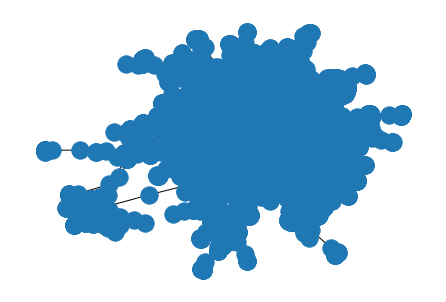

In [16]:
c=0
for component in list(nx.connected_components(G)):
    c += 1
nx.draw(G)
print('number of nodes =',G.number_of_nodes(),', number of edges =', G.number_of_edges(),'. number of components =',c) 

In [17]:
nx.write_gexf(G,'final_net.gexf')

In [18]:
S = [G.subgraph(c).copy() for c in nx.connected_components(G)]
print(len(S))

1


In [19]:
for e in S:
    print(e)

Graph with 10184 nodes and 11968 edges


In [21]:
for i,e in enumerate(S):
    print('component',i)
    print(list(e.nodes.data()))

component 0
[('290883', {'category': 'pax', 'location': 'European Union', 'label': '290883'}), ('1471971', {'category': 'proukr', 'location': 'nan', 'label': '1471971'}), ('2052911', {'category': 'pax', 'location': 'London, England', 'label': '2052911'}), ('2827221', {'category': 'dontcare', 'location': 'NYC', 'label': '2827221'}), ('3688111', {'category': 'proukr', 'location': 'Bangkok', 'label': '3688111'}), ('4254951', {'category': 'proukr', 'location': 'Berkeley CA', 'label': '4254951'}), ('4615341', {'category': 'proukr', 'location': 'Paris of the Piedmont', 'label': '4615341'}), ('4937571', {'category': 'pax', 'location': 'Moss Beach, CA', 'label': '4937571'}), ('5404582', {'category': 'pax', 'location': 'Lugano', 'label': '5404582'}), ('5516892', {'category': 'proukr', 'location': 'Chicago, IL', 'label': '5516892'}), ('5749002', {'category': 'proukr', 'location': "Martha's Vineyard, USA", 'label': '5749002'}), ('5849252', {'category': 'proukr', 'location': 'Ocean City, Maryland'

In [39]:
print(G.edges.data())

[('290883', '2956836471', {'w': 0.0228884590586718, 'id': '0'}), ('1471971', '1205226529455632385', {'w': 0.0, 'id': '2'}), ('2052911', '1401015246718914560', {'w': 0.0667311411992263, 'id': '3'}), ('2052911', '2202063265', {'w': 0.04642166344294, 'id': '4'}), ('2052911', '1317817827970134025', {'w': 0.0177304964539007, 'id': '5'}), ('2052911', '1353366187791560704', {'w': 0.0109606705351386, 'id': '6'}), ('2052911', '316797199', {'w': 0.0096711798839458, 'id': '7'}), ('2827221', '4018888580', {'w': 0.0, 'id': '8'}), ('3688111', '1499295169870319616', {'w': 0.0, 'id': '9'}), ('4254951', '282076470', {'w': 0.0003223726627981, 'id': '10'}), ('4615341', '27493883', {'w': 0.0019342359767891, 'id': '11'}), ('4937571', '4018888580', {'w': 0.0, 'id': '12'}), ('5404582', '2322424306', {'w': 0.0003223726627981, 'id': '13'}), ('5516892', '4018888580', {'w': 0.0, 'id': '14'}), ('5749002', '2301844336', {'w': 0.0, 'id': '15'}), ('5849252', '1142623492141211650', {'w': 0.0003223726627981, 'id': '16

In [55]:
c_proukr = 0
c_pax = 0
c_nocare = 0
c_prorus= 0

for i,e in enumerate(S):
    for node in e.nodes.data():
        for idx,attribute in node[1].items():
            if attribute == "proukr":
                c_proukr += 1 
            elif attribute == "pax":
                c_pax += 1
            elif attribute == "prorus":
                c_prorus += 1
            elif attribute == "nocare":
                c_nocare += 1

print('TOT USERS = {} \n'
      'proukr = {} \n'
      'pax = {} \n'
      'prorus = {} \n'
      'nocare = {} \n'.format(len(G.nodes),c_proukr,c_pax, c_prorus, c_nocare))
            

TOT USERS = 10184 
proukr = 6922 
pax = 2165 
prorus = 416 
nocare = 0 



In [66]:
def make_node_df(G):
    nodes = {}
    for node, attribute in G.nodes(data=True):
        if not nodes.get('node'):
            nodes['node'] = [node]
        else:
            nodes['node'].append(node)

        for key, value in attribute.items():
            if not nodes.get(key):
                nodes[key] = [value]
            else:
                nodes[key].append(value)

    return pd.DataFrame(nodes)

def make_edge_df(G):
    edges = {}
    for source, target, attribute in G.edges(data=True):

        if not edges.get('source'):
            edges['source'] = [source]
        else:
            edges['source'].append(source)

        if not edges.get('target'):
            edges['target'] = [target]
        else:
            edges['target'].append(target)

        for key, value in attribute.items():
            if not edges.get(key):
                edges[key] = [value]
            else:
                edges[key].append(value)
    return pd.DataFrame(edges)

In [72]:
df_final_nodes=make_node_df(G)
df_final_nodes.to_csv('df_final_nodes')

In [73]:
df_final_edges=make_edge_df(G)
df_final_edges.to_csv('df_final_edges')